# Analysis of wind simulation and different scan angles for laser scanning of vegetation


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In this script, we read in simulated point cloud data. The data is separated by three flight strips and by the different wind speeds. For every wind speed > 0, five snapshots have been captured and are analysed.

First, we collect the Z coordinates of all points per strip and windspeed and calculate the mean (`dict` meanH). We also collect the individual points - per each windspeed - in an additional `dict` pts_windspeed.
To analyse the effect of the different scan angles, we also collect the mean heights calculated for a single snapshot in a `dict` meanH_fl:

In [2]:
heights = []

for folder in tqdm(list(Path(r'output').glob('*'))):
    if not folder.is_dir():
        continue
    run = next(folder.iterdir())
    files = run.glob("*.xyz")
    for f in files:
        points = pd.read_csv(f, sep=' ', header=None, names='X Y Z intensity echoWidth returnNumber numberOfReturns fullwaveIndex hitObjectId class gpsTime'.split(' '))
        ws = float(f.parent.parent.name.replace('mapleFlight', '').split('ID')[0].split('WS')[1])
        id = int(f.parent.parent.name.replace('mapleFlight', '').split('ID')[1])
        str = int(f.name.split('leg')[1].split('_points')[0])
        treepoints = points[points['hitObjectId'] == 1]
        heights.append(np.stack([treepoints['Z'], np.full_like(treepoints['Z'], ws), np.full_like(treepoints['Z'], id), np.full_like(treepoints['Z'], str)]).T)
        
heights = pd.DataFrame(np.concatenate(heights), columns=['z', 'ws', 'id', 'strip'])
meanH_by_ws_and_id = heights.groupby(['ws', 'id']).mean()
meanH_by_ws_and_id_and_strip = heights.groupby(['ws', 'id', 'strip']).mean()

  0%|          | 0/36 [00:00<?, ?it/s]

Now we can analyse the variance and the root mean square differences (RMSD) in mean height for these groups.
We look at the RMSD between datasets that are simulated with wind (using the 5 snapshots each) to the one simulated without wind, as well as their standard deviation. This value is quantified on the merged flight strips. Additionally, we plot the RMSD values against the simulated wind speed.

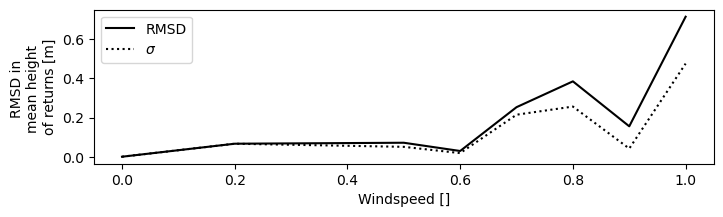

In [3]:
rmsds = []
stds = []
wss = meanH_by_ws_and_id.index.get_level_values(0).unique()
meanH_0 = meanH_by_ws_and_id.query("ws==0")["z"].item()
for ws in wss:
    vals = meanH_by_ws_and_id.query(f"ws=={ws}")
    rmsd = np.sqrt(np.mean(np.square(vals["z"]-meanH_0)))
    stddev= np.std(vals)[0]
    rmsds.append(rmsd)
    stds.append(stddev)

plt.figure(figsize=(8,2))
plt.plot(wss, rmsds, 'k-', label='RMSD')
plt.plot(wss, stds, 'k:', label='$\sigma$')
plt.xlabel("Windspeed []")
plt.ylabel("RMSD in \nmean height \nof returns [m]")
plt.legend()
plt.show()

We can see that starting with a windspeed of 0.7, both the standard deviation and the RMSD increase sharply. Also, at windspeed 0.9, favourable conditions seem to manifest, before the RMSD and standard deviation increase again for a windspeed of 1.0. What does the RMSD look like if we restrict points to single flight strips?

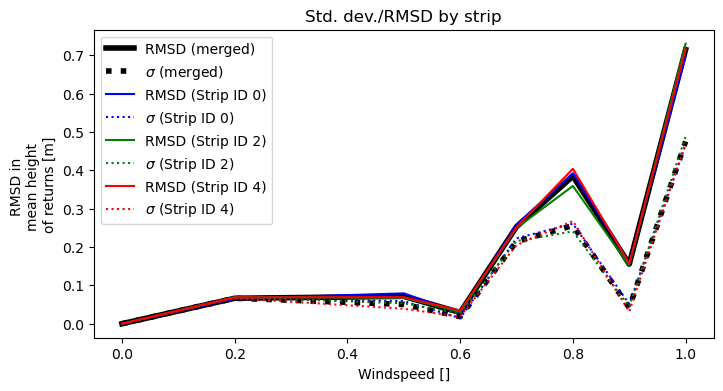

In [4]:

wss = meanH_by_ws_and_id_and_strip.index.get_level_values(0).unique()

plt.figure(figsize=(8,4))
plt.title(f"Std. dev./RMSD by strip")
plt.plot(wss, rmsds, f'k-', label=f'RMSD (merged)', lw=4)
plt.plot(wss, stds, f'k:', label=f'$\sigma$ (merged)', lw=4)

for strip, col in zip([0, 2, 4], 'bgr'):
    rmsds = []
    stds = []
    meanH_0 = meanH_by_ws_and_id_and_strip.query(f"ws==0 & strip=={strip}")["z"].item()
    for ws in wss:
        vals = meanH_by_ws_and_id_and_strip.query(f"ws=={ws} & strip=={strip}")["z"]
        rmsd = np.sqrt(np.mean(np.square(vals-meanH_0)))
        stddev= np.std(vals)
        rmsds.append(rmsd)
        stds.append(stddev)
    
    plt.plot(wss, rmsds, f'{col}-', label=f'RMSD (Strip ID {strip})')
    plt.plot(wss, stds, f'{col}:', label=f'$\sigma$ (Strip ID {strip})')
plt.xlabel("Windspeed []")
plt.ylabel("RMSD in \nmean height \nof returns [m]")
plt.legend()
plt.show()

There is neither a big difference to the merged dataset nor between the individual strips, in either of RMSD or standard deviation. This is already a hint that the contribution from the different scan angles is much smaller than the one from the simulated wind. But let's quantify this contribution:

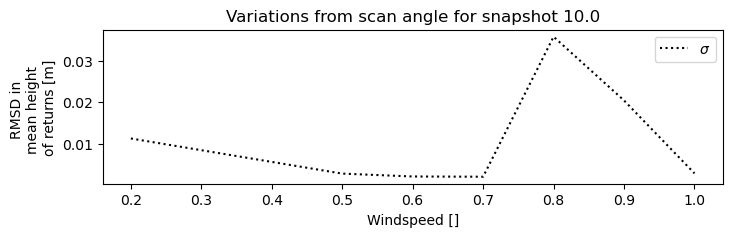

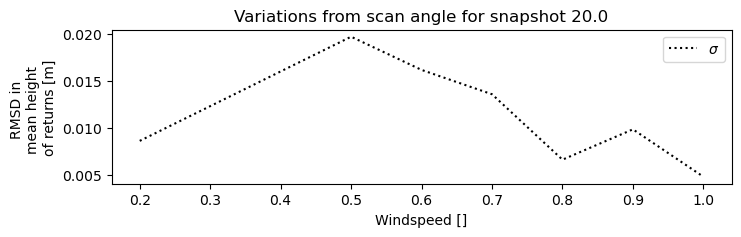

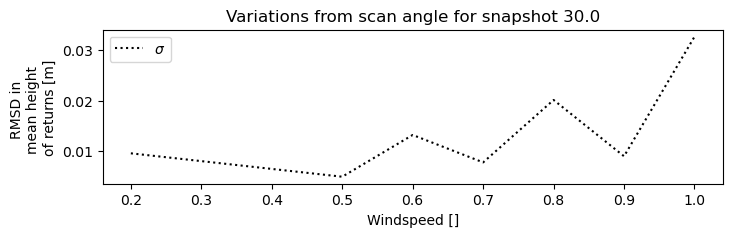

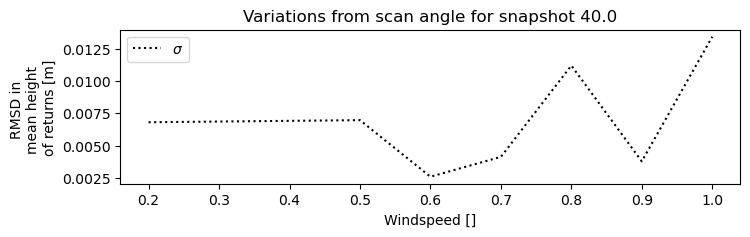

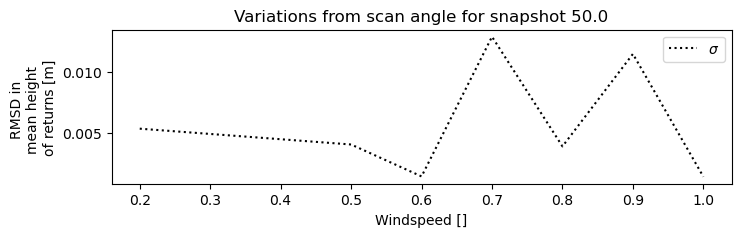

In [5]:

wss = meanH_by_ws_and_id_and_strip.index.get_level_values(0).unique()

for id in meanH_by_ws_and_id_and_strip.index.get_level_values(1).unique()[1:]:
    stds = []
    
    for ws in wss:
        vals = meanH_by_ws_and_id_and_strip.query(f"ws=={ws} & id=={id}")
        stddev = np.std(vals)[0]
        stds.append(stddev)
    
    plt.figure(figsize=(8,2))
    plt.title(f'Variations from scan angle for snapshot {id}')
    plt.plot(wss, stds, 'k:', label='$\sigma$')
    plt.xlabel("Windspeed []")
    plt.ylabel("RMSD in \nmean height \nof returns [m]")
    plt.legend()
    plt.show()

Depending on the snapshot we look at, we see different patterns, but no clear correspondence with the wind speed. However, the magnitudes of the standard deviation are at around 1-3 cm, while as for the different snapshots, they were up to 70 cm at windspeed 1!